In [ ]:
!pip uninstall -y xgboost
!pip install -U xgboost

Found existing installation: xgboost 3.1.2
Uninstalling xgboost-3.1.2:
  Successfully uninstalled xgboost-3.1.2
  Using cached xgboost-3.1.2-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.2-py3-none-manylinux_2_28_x86_64.whl (115.9 MB)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import xgboost
print(xgboost.__version__)

3.1.2


In [ ]:
!pip install rdkit


In [ ]:
!pip install -q xgboost scikit-learn matplotlib seaborn



In [ ]:
%cd drive/MyDrive/projects/toxicity-multiclass
!ls


/content/drive/MyDrive/projects/toxicity-multiclass
chapters  models     pyproject.toml  results  src
data	  notebooks  README.md	     scripts


In [ ]:
import sys
sys.path.insert(0, '.')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.toxicity.models.xgboost_multilabel import (
    MultiLabelXGBoost,
    evaluate_multilabel,
    TOX21_ASSAYS
)

sns.set_style('whitegrid')
print("Imports complete!")

Imports complete!


In [ ]:
print(" Loading data...\n")


# DataFrames (after featurization)
train_df = pd.read_csv('data/processed/train_clean_featurized.csv')
val_df = pd.read_csv('data/processed/val_clean_featurized.csv')
test_df = pd.read_csv('data/processed/test_clean_featurized.csv')

print(f"DataFrames loaded:")
print(f"   Train: {len(train_df):,} molecules")
print(f"   Val:   {len(val_df):,} molecules")
print(f"   Test:  {len(test_df):,} molecules")

# Load fingerprints (features)
X_train = np.load('data/features/X_train_morgan.npy')
X_val = np.load('data/features/X_val_morgan.npy')
X_test = np.load('data/features/X_test_morgan.npy')

print(f"\nFingerprints loaded:")
print(f"   Train: {X_train.shape}")
print(f"   Val:   {X_val.shape}")
print(f"   Test:  {X_test.shape}")

# Extract labels
y_train = train_df[TOX21_ASSAYS].values.astype(float)
y_val = val_df[TOX21_ASSAYS].values.astype(float)
y_test = test_df[TOX21_ASSAYS].values.astype(float)

print(f"\nLabels extracted:")
print(f"   Train: {y_train.shape}")
print(f"   Val:   {y_val.shape}")
print(f"   Test:  {y_test.shape}")

print(f"\n Data loaded successfully!")

 Loading data...

DataFrames loaded:
   Train: 6,162 molecules
   Val:   777 molecules
   Test:  778 molecules

Fingerprints loaded:
   Train: (6162, 2048)
   Val:   (777, 2048)
   Test:  (778, 2048)

Labels extracted:
   Train: (6162, 12)
   Val:   (777, 12)
   Test:  (778, 12)

 Data loaded successfully!


In [ ]:
# Quick data check
print(" Data Quality Check\n")

# Checking for NaN in features
print(f"Features (X_train):")
print(f"   NaN values: {np.isnan(X_train).sum()}")
print(f"   Sparsity: {(X_train == 0).sum() / X_train.size * 100:.1f}%")

# Checking label distribution
print(f"\nLabels (y_train):")
for i, assay in enumerate(TOX21_ASSAYS):
    valid = y_train[:, i][~np.isnan(y_train[:, i])]
    if len(valid) > 0:
        pos_rate = (valid == 1).sum() / len(valid) * 100
        print(f"   {assay:<20} Positive: {pos_rate:5.1f}%")

 Data Quality Check

Features (X_train):
   NaN values: 0
   Sparsity: 98.5%

Labels (y_train):
   NR-AR                Positive:   4.5%
   NR-AR-LBD            Positive:   3.6%
   NR-AhR               Positive:  11.8%
   NR-Aromatase         Positive:   4.9%
   NR-ER                Positive:  12.4%
   NR-ER-LBD            Positive:   4.7%
   NR-PPAR-gamma        Positive:   2.7%
   SR-ARE               Positive:  16.0%
   SR-ATAD5             Positive:   3.5%
   SR-HSE               Positive:   5.7%
   SR-MMP               Positive:  15.3%
   SR-p53               Positive:   6.2%


In [ ]:
# Initialize model
model = MultiLabelXGBoost(
    task_names=TOX21_ASSAYS,
    xgb_params={
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'objective': 'binary:logistic',
        'random_state': 42,
        'n_jobs': -1
    },
    use_gpu=True,
    verbose=1
)

print("\n Model initialized")

 MultiLabelXGBoost initialized (12 tasks)

 Model initialized


In [ ]:
# Training the model (without early stopping had problems setting up the latest version of xgboost couldnt figure it out so i took it off)
import time

print("\n Starting training...\n")
start_time = time.time()


model.fit(
    X_train, y_train,
    X_val, y_val,
    early_stopping_rounds=10
)

training_time = time.time() - start_time

print(f"\n   Training completed in {training_time:.1f} seconds ({training_time/60:.1f} minutes)")


 Starting training...

 Trained NR-AR
 Trained NR-AR-LBD
 Trained NR-AhR
 Trained NR-Aromatase
 Trained NR-ER
 Trained NR-ER-LBD
 Trained NR-PPAR-gamma
 Trained SR-ARE
 Trained SR-ATAD5
 Trained SR-HSE
 Trained SR-MMP
 Trained SR-p53

   Training completed in 35.6 seconds (0.6 minutes)


In [ ]:
# Predict on validation set
print("Making predictions on validation set...\n")

y_val_pred = model.predict(X_val,0.7)
y_val_proba = model.predict_proba(X_val)

print(f" Predictions shape: {y_val_pred.shape}")
print(f"   Probabilities shape: {y_val_proba.shape}")

Making predictions on validation set...

 Predictions shape: (777, 12)
   Probabilities shape: (777, 12)


In [ ]:
# Comprehensive evaluation
val_results = evaluate_multilabel(
    y_val,
    y_val_pred,
    y_val_proba,
    TOX21_ASSAYS)

In [ ]:
# Predict on test set
print("Making predictions on test set...\n")

y_test_pred = model.predict(X_test,0.7)
y_test_proba = model.predict_proba(X_test)

# Evaluate
test_results = evaluate_multilabel(
    y_test,
    y_test_pred,
    y_test_proba,
    TOX21_ASSAYS)

Making predictions on test set...



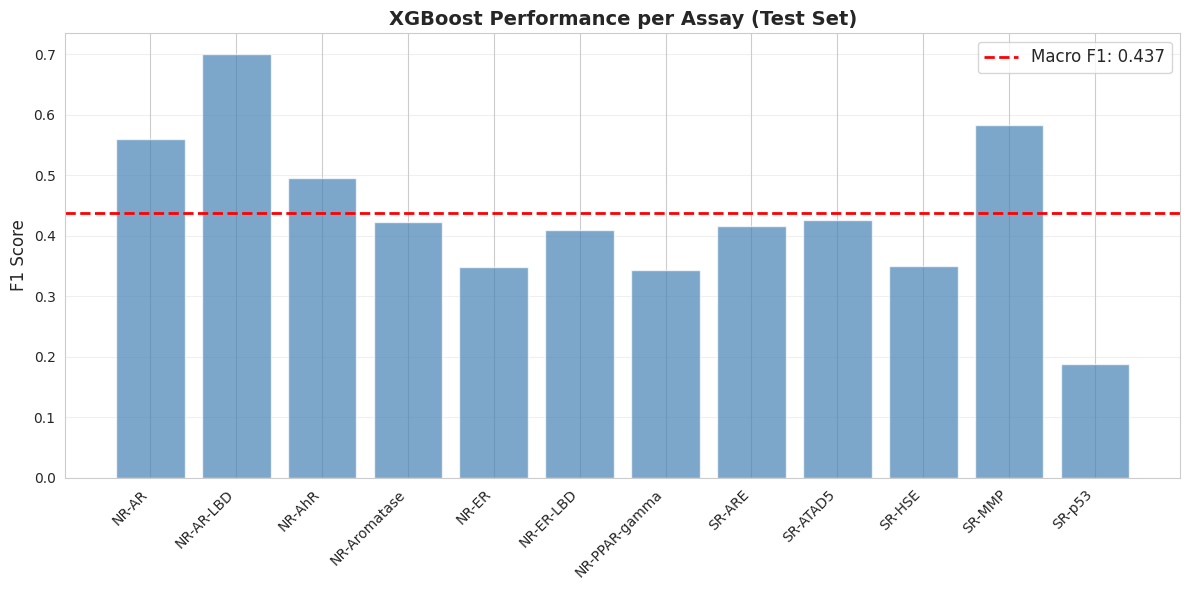

Saved: results/figures/xgboost_performance.png


In [ ]:
# Plot per-task F1 scores
fig, ax = plt.subplots(figsize=(12, 6))

tasks = list(test_results['per_task'].keys())
f1_scores = [test_results['per_task'][t]['f1'] for t in tasks]

bars = ax.bar(range(len(tasks)), f1_scores, color='steelblue', alpha=0.7)
ax.axhline(y=test_results['aggregate']['macro_f1'],
           color='red', linestyle='--', linewidth=2,
           label=f"Macro F1: {test_results['aggregate']['macro_f1']:.3f}")

ax.set_xticks(range(len(tasks)))
ax.set_xticklabels(tasks, rotation=45, ha='right')
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('XGBoost Performance per Assay (Test Set)', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/xgboost_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: results/figures/xgboost_performance.png")

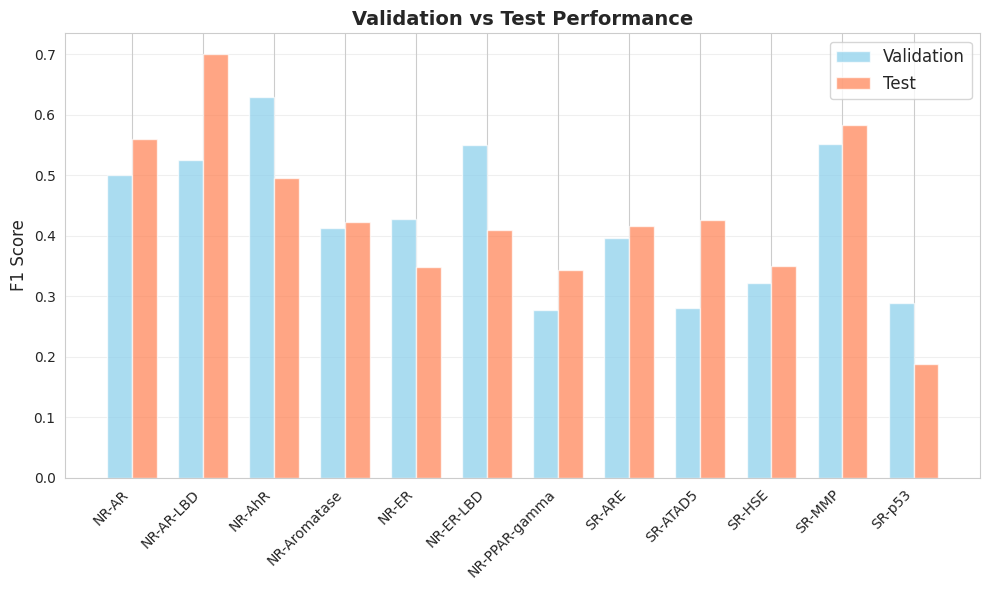

Saved: results/figures/val_vs_test.png


In [ ]:
# Plot comparison: Validation vs Test
fig, ax = plt.subplots(figsize=(10, 6))

val_f1s = [val_results['per_task'][t]['f1'] for t in tasks]
test_f1s = [test_results['per_task'][t]['f1'] for t in tasks]

x = np.arange(len(tasks))
width = 0.35

ax.bar(x - width/2, val_f1s, width, label='Validation', color='skyblue', alpha=0.7)
ax.bar(x + width/2, test_f1s, width, label='Test', color='coral', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(tasks, rotation=45, ha='right')
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Validation vs Test Performance', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/val_vs_test.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: results/figures/val_vs_test.png")

In [ ]:
import os
import json
import numpy as np

# Ensure folders exist
os.makedirs("models/xgboost_baseline", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Compute macro ROC-AUC (mean over tasks, ignore NaN)
def compute_macro_roc_auc(results):
    aucs = [
        m["roc_auc"]
        for m in results["per_task"].values()
        if not np.isnan(m["roc_auc"])
    ]
    return float(np.mean(aucs)) if len(aucs) > 0 else float("nan")

val_results["aggregate"]["macro_roc_auc"] = compute_macro_roc_auc(val_results)
test_results["aggregate"]["macro_roc_auc"] = compute_macro_roc_auc(test_results)

# Save trained model
model.save("models/xgboost_baseline")

# Save results
results_summary = {
    "model": "XGBoost Multi-Label Baseline",
    "training_time_seconds": float(training_time),
    "validation": {
        "macro_f1": float(val_results["aggregate"]["macro_f1"]),
        "macro_roc_auc": float(val_results["aggregate"]["macro_roc_auc"]),
    },
    "test": {
        "macro_f1": float(test_results["aggregate"]["macro_f1"]),
        "macro_roc_auc": float(test_results["aggregate"]["macro_roc_auc"]),
        "per_task": {},
    },
}

for task in TOX21_ASSAYS:
    if task in test_results["per_task"]:
        results_summary["test"]["per_task"][task] = {
            "f1": float(test_results["per_task"][task]["f1"]),
            "roc_auc": float(test_results["per_task"][task]["roc_auc"]),
        }

with open("results/xgboost_results.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print(" Model and results saved!")


 Model and results saved!


In [ ]:
print("\n" + "="*80)
print("FINAL RESULTS - TEST SET")
print("="*80)

print(f"\n Overall Performance:")
print(f"   Macro F1:      {test_results['aggregate']['macro_f1']:.4f}")
print(f"   Macro ROC-AUC: {test_results['aggregate']['macro_roc_auc']:.4f}")

print(f"\n Best Performing Assays:")
sorted_tasks = sorted(
    test_results['per_task'].items(),
    key=lambda x: x[1]['f1'],
    reverse=True
)[:3]

for task, metrics in sorted_tasks:
    print(f"   {task:<20} F1: {metrics['f1']:.4f}")

print(f"\n Most Challenging Assays:")
sorted_tasks = sorted(
    test_results['per_task'].items(),
    key=lambda x: x[1]['f1']
)[:3]

for task, metrics in sorted_tasks:
    print(f"   {task:<20} F1: {metrics['f1']:.4f}")

print("\n" + "="*80)


FINAL RESULTS - TEST SET

 Overall Performance:
   Macro F1:      0.4371
   Macro ROC-AUC: 0.7852

 Best Performing Assays:
   NR-AR-LBD            F1: 0.7000
   SR-MMP               F1: 0.5838
   NR-AR                F1: 0.5600

 Most Challenging Assays:
   SR-p53               F1: 0.1875
   NR-PPAR-gamma        F1: 0.3429
   NR-ER                F1: 0.3492

